In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm

import pandas as pd

In [35]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

In [36]:
def normalize_feature(feature, feature_name):
    """ Normalize features except 'PrevFireMask'. """
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    """ Parses TFRecord into tensors and normalizes features. """
    feature_description = {feat: tf.io.FixedLenFeature([64, 64], tf.float32) for feat in INPUT_FEATURES + OUTPUT_FEATURES}

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = [normalize_feature(tf.expand_dims(parsed_example[feat], -1), feat) for feat in INPUT_FEATURES]
    inputs = tf.concat(inputs_list, axis=-1)  # Convert to NumPy

    label = tf.expand_dims(parsed_example['FireMask'], -1)  # Shape: [64, 64, 1]
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label

In [37]:
import random
def random_crop(x, crop_size):
    c, h, w = x.shape
    top = np.random.randint(0, h - crop_size + 1)
    left = np.random.randint(0, w - crop_size + 1)
    return x[:, top:top+crop_size, left:left+crop_size]

In [38]:
class WildfireDataset(Dataset):
    def __init__(self, tf_dataset, random_crop_flag=False, crop_size=32):
        self.data = list(tf_dataset.as_numpy_iterator()) # Correctly iterate over the dataset
        self.crop_size = crop_size
        self.random_crop_flag = random_crop_flag

    def __len__(self):
        """ Return dataset size. """
        return len(self.data)

    def __getitem__(self, idx):
        """ Get a single sample. """
        inputs, label = self.data[idx]
        # inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to PyTorch tensor
        # label = torch.tensor(label, dtype=torch.float32)
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        label = torch.tensor(label, dtype=torch.float32).permute(2, 0, 1)       # [H, W, 1] → [1, H, W] if needed
        if self.random_crop_flag:
            inputs, label = random_crop(inputs, self.crop_size), random_crop(label, self.crop_size)
        return inputs, label

In [39]:
def get_tensorflow_dataset(file_pattern):
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [40]:
train_file = '../data/next_day_wildfire_spread_train*'
val_file = '../data/next_day_wildfire_spread_eval*'
test_file = '../data/next_day_wildfire_spread_test*'

In [41]:
# Convert train, validation, and test datasets
train_numpy = get_tensorflow_dataset(train_file)
val_numpy = get_tensorflow_dataset(val_file)
test_numpy = get_tensorflow_dataset(test_file)

# Create PyTorch datasets (without Cropping)
train_dataset = WildfireDataset(train_numpy)
val_dataset = WildfireDataset(val_numpy)
test_dataset = WildfireDataset(test_numpy)

In [42]:
class ResBlock3(nn.Module):
  def __init__(self, in_c, mid_c, out_c,
               dropout= 0.1, batch_norm=True, pool_size=2,
               kernel_size=3, strides=(1,1), padding=1):
    super(ResBlock3, self).__init__()

    self.same_c = in_c == out_c
    self.in_c = in_c
    self.mid_c = mid_c
    self.out_c = out_c
    layers = []
    if batch_norm:
      layers.append(nn.BatchNorm2d(in_c))

      layers.extend([
        nn.LeakyReLU(),
        nn.Dropout2d(dropout)
        ]
    )

    if strides[0] ==1:
      # by default, no downsampling needed. and the stride normally is 1
      layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size,
                              padding=padding, stride=strides[0]))
    else:
      layers.append(
          nn.MaxPool2d(pool_size, strides[0])
          )
      if self.in_c != self.mid_c:
        layers.append(nn.Conv2d(in_c, mid_c, kernel_size=1))

    if batch_norm:
       layers.append(nn.BatchNorm2d(mid_c))

    layers.extend([
        nn.LeakyReLU(),
        nn.Dropout2d(dropout),
        nn.Conv2d(mid_c, out_c, kernel_size=kernel_size, stride=strides[1],
                  padding=padding),
        nn.Dropout2d(dropout)
    ])
    self.net = nn.Sequential(*layers)

    self.shortcut = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=1,padding=0,stride=strides[0]),
        nn.BatchNorm2d(out_c) if batch_norm else nn.Identity(),
        nn.Dropout(dropout)
    )


  def forward(self,x):
    #print(f"ResBlock3 input shape: {x.shape}")
    x1 = self.net(x)
    x2 = self.shortcut(x)
    out = x1 + x2
    return out

## AutoEncoder

In [43]:
class Autoencoder(nn.Module):
  def __init__(self,
               in_channels, out_channels,
               encoder_layers, encoder_pools,
               decoder_layers, decoder_pools,
               dropout=0.1, batch_norm=True,
               ):
    super(Autoencoder, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.encoder_layers = encoder_layers
    self.decoder_layers = decoder_layers
    self.encoder_pools = encoder_pools
    self.decoder_pools = decoder_pools
    self.dropout = dropout
    self.batch_norm = batch_norm

    self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels, encoder_layers[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(encoder_layers[0]) if batch_norm else nn.Identity(),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(encoder_layers[0], encoder_layers[0], kernel_size=3, padding=1),
            nn.Dropout2d(dropout)
        )
    self.input_shortcut = nn.Sequential(
        nn.Conv2d(in_channels, encoder_layers[0], kernel_size=1, padding=0),
        nn.BatchNorm2d(encoder_layers[0]) if batch_norm else nn.Identity(),
        nn.Dropout2d(dropout)
    )

    self.encoder_blocks = nn.ModuleList()
    for i in range(len(encoder_layers) - 1):
      self.encoder_blocks.append(
          ResBlock3(encoder_layers[i], encoder_layers[i+1],encoder_layers[i+1],
                    dropout=dropout, batch_norm=batch_norm,
                    pool_size=encoder_pools[i+1],
                    strides=(encoder_pools[i+1],1)
          )
      )

    self.bottleneck = ResBlock3(
       in_c=encoder_layers[-1],
       mid_c=encoder_layers[-1],
       out_c=encoder_layers[-1],
       dropout=dropout,
       batch_norm=batch_norm
    )


    self.decoder_blocks = nn.ModuleList()
    for i in range(len(decoder_layers)):
      self.decoder_blocks.append(
          nn.Sequential(
              nn.Upsample(scale_factor=decoder_pools[i], mode='nearest'),
              ResBlock3(
                  in_c = encoder_layers[-1] if i==0 else decoder_layers[i-1],
                  mid_c= decoder_layers[i], out_c=decoder_layers[i],
                  dropout=dropout, batch_norm=batch_norm
                  )
          )
      )

    # Output convolution (explicitly using out_channels)
    self.output_conv = nn.Conv2d(decoder_layers[-1],
                                 self.out_channels, kernel_size=1)

  def forward(self,x):
    x1 = self.input_conv(x)
    shortcut = self.input_shortcut(x)

    x2 = x1 + shortcut
    for encoder_block in self.encoder_blocks:
      x2 = encoder_block(x2)

    x2 = self.bottleneck(x2)

    for decoder_block in self.decoder_blocks:
      x2 = decoder_block(x2)

    x2 = self.output_conv(x2)
    return x2

In [44]:
params_config = {
    'in_channels': 12,
    'out_channels': 1,
    'encoder_layers': [16, 16, 32],
    'decoder_layers': [32, 16],
    'encoder_pools': [1, 2, 2],
    'decoder_pools': [2, 2],
    'dropout': 0.1,
    'batch_norm': True
}

In [45]:
model1 = Autoencoder(**params_config)

In [46]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
import numpy as np

In [47]:
def evaluate_model_metrics(model, data_loader, threshold=0.5, device=None):
    """
    Evaluate model using multiple metrics: AUC PR, Precision, Recall, and F1-score.

    Args:
        model: The trained model to evaluate
        data_loader: Data loader for evaluation
        threshold: Classification threshold (default 0.5)
        device: Device to use for evaluation

    Returns:
        metrics: Dictionary containing AUC PR, precision, recall, and F1-score
    """

    model.eval()

    all_targets = []
    all_predictions = []
    all_binary_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(outputs)

            # Binary predictions using threshold
            binary_preds = (probs > threshold).float()

            # Collect all predictions and targets
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(probs.cpu().numpy())
            all_binary_predictions.append(binary_preds.cpu().numpy())

    # Concatenate all batches
    all_targets = np.concatenate(all_targets).flatten()
    all_predictions = np.concatenate(all_predictions).flatten()
    all_binary_predictions = np.concatenate(all_binary_predictions).flatten()

    # Calculate metrics
    auc_pr = average_precision_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_binary_predictions, zero_division=0)
    recall = recall_score(all_targets, all_binary_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_binary_predictions, zero_division=0)

    metrics = {
        'auc_pr': auc_pr,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

In [48]:
def train_model(model, train_loader, val_loader, lr=0.001,pos_weight=3.0, num_epochs=10, device=None):
    """Train the wildfire segmentation model with comprehensive metrics."""
    # Set device
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([pos_weight], device=device)
    )

    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_reg_loss': [],
        'val_reg_loss': [],
        'val_auc_pr': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1_score': []
    }

    # Best model tracking
    best_auc_pr = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_reg_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate losses
            bce_loss = criterion(outputs, targets)
            #reg_loss = model.get_regularization_loss()
            #total_loss = bce_loss + reg_loss
            total_loss = bce_loss

            total_loss.backward()
            optimizer.step()

            train_loss += bce_loss.item() * inputs.size(0)
            #train_reg_loss += reg_loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        #avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        #history['train_reg_loss'].append(avg_train_reg_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        #val_reg_loss = 0.0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                # Calculate losses
                bce_loss = criterion(outputs, targets)
                #reg_loss = model.get_regularization_loss()

                val_loss += bce_loss.item() * inputs.size(0)
                #val_reg_loss += reg_loss.item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        #avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)
        #history['val_reg_loss'].append(avg_val_reg_loss)

        # Calculate metrics
        metrics = evaluate_model_metrics(model, val_loader, device=device)

        # Store metrics in history
        for metric_name, metric_value in metrics.items():
            history[f'val_{metric_name}'].append(metric_value)

        # Save best model based on AUC PR
        auc_pr = metrics['auc_pr']
        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model_state = model.state_dict().copy()
            print(f"New best model with AUC PR: {best_auc_pr:.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"AUC PR: {metrics['auc_pr']:.4f} "
              f"Precision: {metrics['precision']:.4f} "
              f"Recall: {metrics['recall']:.4f} "
              f"F1: {metrics['f1_score']:.4f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    final_metrics = evaluate_model_metrics(model, val_loader, device=device)
    print("\nFinal Model Performance:")
    print(f"AUC PR: {final_metrics['auc_pr']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1_score']:.4f}")

    return model, history, final_metrics

In [49]:
lr = 0.0001
pos_weight = 3.0
num_epochs = 100

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_sizes = [64]

In [51]:
results = []
histories = {}

In [ ]:
for batch in batch_sizes:
    print(f"\n🔁 Training with batch size: {batch}")
    
    # Fresh model for each run
    model = Autoencoder(**params_config)

    # DataLoaders for current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Train model
    model_trained, history, final_metrics = train_model(
        model,
        train_loader,
        val_loader,
        lr=lr,
        pos_weight=pos_weight,
        num_epochs=num_epochs,
        device=device
    )

    # Store results and history
    results.append({
        'batch_size': batch,
        'learning_rate': lr,
        'pos_weight': pos_weight,
        **final_metrics
    })
    histories[batch] = history

# Save results to CSV for later analysis
results_df = pd.DataFrame(results)


🔁 Training with batch size: 64


[Epoch 1/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


New best model with AUC PR: 0.0200
Epoch [1/100] Train Loss: 0.3827 Val Loss: 0.1957 AUC PR: 0.0200 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 2/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]


New best model with AUC PR: 0.0795
Epoch [2/100] Train Loss: 0.1554 Val Loss: 0.1501 AUC PR: 0.0795 Precision: 0.0990 Recall: 0.0022 F1: 0.0043


[Epoch 3/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


New best model with AUC PR: 0.1418
Epoch [3/100] Train Loss: 0.1154 Val Loss: 0.1278 AUC PR: 0.1418 Precision: 0.2367 Recall: 0.2453 F1: 0.2410


[Epoch 4/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


New best model with AUC PR: 0.1461
Epoch [4/100] Train Loss: 0.0989 Val Loss: 0.1262 AUC PR: 0.1461 Precision: 0.2454 Recall: 0.2246 F1: 0.2345


[Epoch 5/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


New best model with AUC PR: 0.1540
Epoch [5/100] Train Loss: 0.0945 Val Loss: 0.1255 AUC PR: 0.1540 Precision: 0.2475 Recall: 0.2356 F1: 0.2414


[Epoch 6/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.82it/s]


Epoch [6/100] Train Loss: 0.0923 Val Loss: 0.1266 AUC PR: 0.1524 Precision: 0.2493 Recall: 0.2272 F1: 0.2377


[Epoch 7/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


New best model with AUC PR: 0.1569
Epoch [7/100] Train Loss: 0.0912 Val Loss: 0.1251 AUC PR: 0.1569 Precision: 0.2574 Recall: 0.1949 F1: 0.2219


[Epoch 8/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


Epoch [8/100] Train Loss: 0.0898 Val Loss: 0.1255 AUC PR: 0.1567 Precision: 0.2543 Recall: 0.2129 F1: 0.2318


[Epoch 9/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


Epoch [9/100] Train Loss: 0.0892 Val Loss: 0.1237 AUC PR: 0.1567 Precision: 0.2509 Recall: 0.2317 F1: 0.2409


[Epoch 10/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]


New best model with AUC PR: 0.1573
Epoch [10/100] Train Loss: 0.0885 Val Loss: 0.1246 AUC PR: 0.1573 Precision: 0.2552 Recall: 0.2068 F1: 0.2285


[Epoch 11/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.78it/s]


New best model with AUC PR: 0.1577
Epoch [11/100] Train Loss: 0.0882 Val Loss: 0.1222 AUC PR: 0.1577 Precision: 0.2583 Recall: 0.1959 F1: 0.2228


[Epoch 12/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


New best model with AUC PR: 0.1592
Epoch [12/100] Train Loss: 0.0873 Val Loss: 0.1247 AUC PR: 0.1592 Precision: 0.2628 Recall: 0.1601 F1: 0.1990


[Epoch 13/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


New best model with AUC PR: 0.1592
Epoch [13/100] Train Loss: 0.0873 Val Loss: 0.1223 AUC PR: 0.1592 Precision: 0.2561 Recall: 0.2193 F1: 0.2363


[Epoch 14/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Epoch [14/100] Train Loss: 0.0869 Val Loss: 0.1234 AUC PR: 0.1585 Precision: 0.2532 Recall: 0.2367 F1: 0.2446


[Epoch 15/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


Epoch [15/100] Train Loss: 0.0866 Val Loss: 0.1229 AUC PR: 0.1579 Precision: 0.2564 Recall: 0.2215 F1: 0.2377


[Epoch 16/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]


Epoch [16/100] Train Loss: 0.0862 Val Loss: 0.1220 AUC PR: 0.1588 Precision: 0.2586 Recall: 0.2106 F1: 0.2321


[Epoch 17/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.79it/s]


New best model with AUC PR: 0.1603
Epoch [17/100] Train Loss: 0.0859 Val Loss: 0.1211 AUC PR: 0.1603 Precision: 0.2632 Recall: 0.1643 F1: 0.2023


[Epoch 18/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


Epoch [18/100] Train Loss: 0.0856 Val Loss: 0.1213 AUC PR: 0.1596 Precision: 0.2613 Recall: 0.1906 F1: 0.2204


[Epoch 19/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


New best model with AUC PR: 0.1607
Epoch [19/100] Train Loss: 0.0854 Val Loss: 0.1214 AUC PR: 0.1607 Precision: 0.2613 Recall: 0.1976 F1: 0.2250


[Epoch 20/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.66it/s]


New best model with AUC PR: 0.1612
Epoch [20/100] Train Loss: 0.0852 Val Loss: 0.1211 AUC PR: 0.1612 Precision: 0.2593 Recall: 0.2219 F1: 0.2392


[Epoch 21/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


New best model with AUC PR: 0.1623
Epoch [21/100] Train Loss: 0.0846 Val Loss: 0.1201 AUC PR: 0.1623 Precision: 0.2596 Recall: 0.2239 F1: 0.2404


[Epoch 22/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.74it/s]


New best model with AUC PR: 0.1627
Epoch [22/100] Train Loss: 0.0850 Val Loss: 0.1206 AUC PR: 0.1627 Precision: 0.2584 Recall: 0.2320 F1: 0.2445


[Epoch 23/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


New best model with AUC PR: 0.1639
Epoch [23/100] Train Loss: 0.0848 Val Loss: 0.1203 AUC PR: 0.1639 Precision: 0.2670 Recall: 0.1584 F1: 0.1988


[Epoch 24/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.82it/s]


Epoch [24/100] Train Loss: 0.0841 Val Loss: 0.1192 AUC PR: 0.1636 Precision: 0.2591 Recall: 0.2286 F1: 0.2429


[Epoch 25/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.36it/s]


New best model with AUC PR: 0.1642
Epoch [25/100] Train Loss: 0.0842 Val Loss: 0.1199 AUC PR: 0.1642 Precision: 0.2577 Recall: 0.2407 F1: 0.2489


[Epoch 26/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


Epoch [26/100] Train Loss: 0.0837 Val Loss: 0.1208 AUC PR: 0.1636 Precision: 0.2575 Recall: 0.2381 F1: 0.2474


[Epoch 27/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.74it/s]


New best model with AUC PR: 0.1662
Epoch [27/100] Train Loss: 0.0837 Val Loss: 0.1189 AUC PR: 0.1662 Precision: 0.2665 Recall: 0.1926 F1: 0.2236


[Epoch 28/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.78it/s]


Epoch [28/100] Train Loss: 0.0836 Val Loss: 0.1187 AUC PR: 0.1659 Precision: 0.2575 Recall: 0.2497 F1: 0.2535


[Epoch 29/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.80it/s]


Epoch [29/100] Train Loss: 0.0833 Val Loss: 0.1191 AUC PR: 0.1660 Precision: 0.2620 Recall: 0.2271 F1: 0.2433


[Epoch 30/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


New best model with AUC PR: 0.1673
Epoch [30/100] Train Loss: 0.0830 Val Loss: 0.1191 AUC PR: 0.1673 Precision: 0.2611 Recall: 0.2312 F1: 0.2452


[Epoch 31/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


New best model with AUC PR: 0.1674
Epoch [31/100] Train Loss: 0.0831 Val Loss: 0.1183 AUC PR: 0.1674 Precision: 0.2635 Recall: 0.2237 F1: 0.2419


[Epoch 32/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


New best model with AUC PR: 0.1689
Epoch [32/100] Train Loss: 0.0828 Val Loss: 0.1178 AUC PR: 0.1689 Precision: 0.2652 Recall: 0.2236 F1: 0.2426


[Epoch 33/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Epoch [33/100] Train Loss: 0.0825 Val Loss: 0.1187 AUC PR: 0.1669 Precision: 0.2602 Recall: 0.2364 F1: 0.2478


[Epoch 34/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.79it/s]


New best model with AUC PR: 0.1696
Epoch [34/100] Train Loss: 0.0827 Val Loss: 0.1174 AUC PR: 0.1696 Precision: 0.2641 Recall: 0.2300 F1: 0.2459


[Epoch 35/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


New best model with AUC PR: 0.1702
Epoch [35/100] Train Loss: 0.0824 Val Loss: 0.1182 AUC PR: 0.1702 Precision: 0.2709 Recall: 0.1941 F1: 0.2262


[Epoch 36/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


Epoch [36/100] Train Loss: 0.0824 Val Loss: 0.1181 AUC PR: 0.1700 Precision: 0.2653 Recall: 0.2315 F1: 0.2472


[Epoch 37/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Epoch [37/100] Train Loss: 0.0819 Val Loss: 0.1181 AUC PR: 0.1685 Precision: 0.2602 Recall: 0.2489 F1: 0.2544


[Epoch 39/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.43it/s]


Epoch [39/100] Train Loss: 0.0818 Val Loss: 0.1166 AUC PR: 0.1714 Precision: 0.2604 Recall: 0.2527 F1: 0.2565


[Epoch 40/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


Epoch [40/100] Train Loss: 0.0816 Val Loss: 0.1167 AUC PR: 0.1723 Precision: 0.2636 Recall: 0.2430 F1: 0.2529


[Epoch 41/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]


New best model with AUC PR: 0.1725
Epoch [41/100] Train Loss: 0.0815 Val Loss: 0.1175 AUC PR: 0.1725 Precision: 0.2654 Recall: 0.2337 F1: 0.2486


[Epoch 42/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]


New best model with AUC PR: 0.1730
Epoch [42/100] Train Loss: 0.0815 Val Loss: 0.1157 AUC PR: 0.1730 Precision: 0.2705 Recall: 0.2192 F1: 0.2422


[Epoch 43/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


New best model with AUC PR: 0.1736
Epoch [43/100] Train Loss: 0.0815 Val Loss: 0.1157 AUC PR: 0.1736 Precision: 0.2678 Recall: 0.2271 F1: 0.2458


[Epoch 44/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


New best model with AUC PR: 0.1742
Epoch [44/100] Train Loss: 0.0813 Val Loss: 0.1175 AUC PR: 0.1742 Precision: 0.2766 Recall: 0.2000 F1: 0.2322


[Epoch 45/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


New best model with AUC PR: 0.1754
Epoch [45/100] Train Loss: 0.0810 Val Loss: 0.1161 AUC PR: 0.1754 Precision: 0.2677 Recall: 0.2371 F1: 0.2515


[Epoch 47/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]


Epoch [47/100] Train Loss: 0.0808 Val Loss: 0.1163 AUC PR: 0.1750 Precision: 0.2671 Recall: 0.2433 F1: 0.2547


[Epoch 48/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Epoch [48/100] Train Loss: 0.0806 Val Loss: 0.1166 AUC PR: 0.1761 Precision: 0.2660 Recall: 0.2481 F1: 0.2568


[Epoch 49/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


New best model with AUC PR: 0.1771
Epoch [49/100] Train Loss: 0.0805 Val Loss: 0.1161 AUC PR: 0.1771 Precision: 0.2756 Recall: 0.2183 F1: 0.2436


[Epoch 50/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]


New best model with AUC PR: 0.1771
Epoch [50/100] Train Loss: 0.0807 Val Loss: 0.1159 AUC PR: 0.1771 Precision: 0.2652 Recall: 0.2530 F1: 0.2590


[Epoch 51/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


New best model with AUC PR: 0.1790
Epoch [51/100] Train Loss: 0.0801 Val Loss: 0.1161 AUC PR: 0.1790 Precision: 0.2752 Recall: 0.2255 F1: 0.2479


[Epoch 53/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Epoch [53/100] Train Loss: 0.0802 Val Loss: 0.1163 AUC PR: 0.1776 Precision: 0.2683 Recall: 0.2456 F1: 0.2565


[Epoch 54/100] Training:  56%|█████▌    | 131/235 [01:32<01:11,  1.46it/s]

New best model with AUC PR: 0.1795
Epoch [54/100] Train Loss: 0.0802 Val Loss: 0.1157 AUC PR: 0.1795 Precision: 0.2705 Recall: 0.2453 F1: 0.2573


[Epoch 55/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


New best model with AUC PR: 0.1804
Epoch [55/100] Train Loss: 0.0799 Val Loss: 0.1153 AUC PR: 0.1804 Precision: 0.2704 Recall: 0.2490 F1: 0.2592


[Epoch 56/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Epoch [56/100] Train Loss: 0.0801 Val Loss: 0.1168 AUC PR: 0.1796 Precision: 0.2721 Recall: 0.2390 F1: 0.2545


[Epoch 57/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.78it/s]


New best model with AUC PR: 0.1807
Epoch [57/100] Train Loss: 0.0798 Val Loss: 0.1153 AUC PR: 0.1807 Precision: 0.2653 Recall: 0.2619 F1: 0.2636


[Epoch 58/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]


Epoch [58/100] Train Loss: 0.0797 Val Loss: 0.1147 AUC PR: 0.1804 Precision: 0.2715 Recall: 0.2473 F1: 0.2588


[Epoch 59/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]


Epoch [59/100] Train Loss: 0.0794 Val Loss: 0.1151 AUC PR: 0.1798 Precision: 0.2694 Recall: 0.2522 F1: 0.2605


[Epoch 61/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


New best model with AUC PR: 0.1811
Epoch [61/100] Train Loss: 0.0796 Val Loss: 0.1173 AUC PR: 0.1811 Precision: 0.2723 Recall: 0.2496 F1: 0.2604


[Epoch 62/100] Training:  52%|█████▏    | 122/235 [01:25<01:17,  1.45it/s]

New best model with AUC PR: 0.1812
Epoch [62/100] Train Loss: 0.0795 Val Loss: 0.1162 AUC PR: 0.1812 Precision: 0.2758 Recall: 0.2380 F1: 0.2555


[Epoch 63/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


New best model with AUC PR: 0.1823
Epoch [63/100] Train Loss: 0.0794 Val Loss: 0.1160 AUC PR: 0.1823 Precision: 0.2814 Recall: 0.2309 F1: 0.2536


[Epoch 64/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


Epoch [64/100] Train Loss: 0.0792 Val Loss: 0.1141 AUC PR: 0.1821 Precision: 0.2629 Recall: 0.2776 F1: 0.2701


[Epoch 65/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


New best model with AUC PR: 0.1826
Epoch [65/100] Train Loss: 0.0793 Val Loss: 0.1156 AUC PR: 0.1826 Precision: 0.2703 Recall: 0.2604 F1: 0.2653


[Epoch 66/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


Epoch [66/100] Train Loss: 0.0791 Val Loss: 0.1154 AUC PR: 0.1825 Precision: 0.2710 Recall: 0.2575 F1: 0.2641


[Epoch 67/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.95it/s]


New best model with AUC PR: 0.1844
Epoch [67/100] Train Loss: 0.0790 Val Loss: 0.1157 AUC PR: 0.1844 Precision: 0.2805 Recall: 0.2339 F1: 0.2551


[Epoch 69/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.43it/s]


Epoch [69/100] Train Loss: 0.0790 Val Loss: 0.1146 AUC PR: 0.1826 Precision: 0.2763 Recall: 0.2451 F1: 0.2598


[Epoch 70/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


Epoch [70/100] Train Loss: 0.0785 Val Loss: 0.1149 AUC PR: 0.1836 Precision: 0.2720 Recall: 0.2616 F1: 0.2667


[Epoch 71/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.56it/s]


Epoch [71/100] Train Loss: 0.0786 Val Loss: 0.1151 AUC PR: 0.1834 Precision: 0.2719 Recall: 0.2571 F1: 0.2643


[Epoch 72/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.49it/s]


New best model with AUC PR: 0.1856
Epoch [72/100] Train Loss: 0.0788 Val Loss: 0.1153 AUC PR: 0.1856 Precision: 0.2812 Recall: 0.2411 F1: 0.2596


[Epoch 73/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Epoch [73/100] Train Loss: 0.0786 Val Loss: 0.1142 AUC PR: 0.1853 Precision: 0.2722 Recall: 0.2616 F1: 0.2668


[Epoch 74/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


Epoch [74/100] Train Loss: 0.0784 Val Loss: 0.1165 AUC PR: 0.1839 Precision: 0.2655 Recall: 0.2738 F1: 0.2696


[Epoch 76/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


New best model with AUC PR: 0.1872
Epoch [76/100] Train Loss: 0.0783 Val Loss: 0.1143 AUC PR: 0.1872 Precision: 0.2790 Recall: 0.2512 F1: 0.2644


[Epoch 77/100] Training:  52%|█████▏    | 122/235 [01:25<01:15,  1.49it/s]

Epoch [77/100] Train Loss: 0.0780 Val Loss: 0.1145 AUC PR: 0.1860 Precision: 0.2752 Recall: 0.2557 F1: 0.2651


[Epoch 78/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.80it/s]


Epoch [78/100] Train Loss: 0.0782 Val Loss: 0.1151 AUC PR: 0.1859 Precision: 0.2830 Recall: 0.2354 F1: 0.2570


[Epoch 79/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Epoch [79/100] Train Loss: 0.0781 Val Loss: 0.1159 AUC PR: 0.1864 Precision: 0.2709 Recall: 0.2713 F1: 0.2711


[Epoch 81/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


New best model with AUC PR: 0.1874
Epoch [81/100] Train Loss: 0.0782 Val Loss: 0.1156 AUC PR: 0.1874 Precision: 0.2834 Recall: 0.2427 F1: 0.2615


[Epoch 82/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]


Epoch [82/100] Train Loss: 0.0780 Val Loss: 0.1145 AUC PR: 0.1864 Precision: 0.2770 Recall: 0.2544 F1: 0.2652


[Epoch 83/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


Epoch [83/100] Train Loss: 0.0778 Val Loss: 0.1158 AUC PR: 0.1845 Precision: 0.2674 Recall: 0.2768 F1: 0.2720


[Epoch 84/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]


Epoch [84/100] Train Loss: 0.0777 Val Loss: 0.1153 AUC PR: 0.1865 Precision: 0.2738 Recall: 0.2671 F1: 0.2704


[Epoch 85/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]


Epoch [85/100] Train Loss: 0.0780 Val Loss: 0.1159 AUC PR: 0.1858 Precision: 0.2628 Recall: 0.2884 F1: 0.2750


[Epoch 87/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]


Epoch [87/100] Train Loss: 0.0775 Val Loss: 0.1156 AUC PR: 0.1863 Precision: 0.2694 Recall: 0.2740 F1: 0.2717


[Epoch 88/100] Training:  58%|█████▊    | 136/235 [01:35<01:08,  1.44it/s]

Epoch [88/100] Train Loss: 0.0776 Val Loss: 0.1157 AUC PR: 0.1861 Precision: 0.2728 Recall: 0.2649 F1: 0.2688


[Epoch 89/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]


New best model with AUC PR: 0.1885
Epoch [89/100] Train Loss: 0.0775 Val Loss: 0.1157 AUC PR: 0.1885 Precision: 0.2791 Recall: 0.2593 F1: 0.2688


[Epoch 90/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Epoch [90/100] Train Loss: 0.0777 Val Loss: 0.1160 AUC PR: 0.1863 Precision: 0.2763 Recall: 0.2580 F1: 0.2668


[Epoch 92/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]


Epoch [92/100] Train Loss: 0.0774 Val Loss: 0.1147 AUC PR: 0.1882 Precision: 0.2679 Recall: 0.2835 F1: 0.2755


[Epoch 93/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]


Epoch [93/100] Train Loss: 0.0772 Val Loss: 0.1153 AUC PR: 0.1871 Precision: 0.2714 Recall: 0.2731 F1: 0.2723


[Epoch 94/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


Epoch [94/100] Train Loss: 0.0774 Val Loss: 0.1148 AUC PR: 0.1858 Precision: 0.2673 Recall: 0.2824 F1: 0.2747


[Epoch 95/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]


Epoch [95/100] Train Loss: 0.0775 Val Loss: 0.1143 AUC PR: 0.1885 Precision: 0.2834 Recall: 0.2458 F1: 0.2632


[Epoch 96/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Epoch [96/100] Train Loss: 0.0773 Val Loss: 0.1145 AUC PR: 0.1869 Precision: 0.2737 Recall: 0.2645 F1: 0.2690


[Epoch 97/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]


Epoch [97/100] Train Loss: 0.0770 Val Loss: 0.1143 AUC PR: 0.1866 Precision: 0.2658 Recall: 0.2789 F1: 0.2722


[Epoch 98/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Epoch [98/100] Train Loss: 0.0771 Val Loss: 0.1166 AUC PR: 0.1889 Precision: 0.2783 Recall: 0.2587 F1: 0.2681


[Epoch 99/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.76it/s]


Epoch [99/100] Train Loss: 0.0771 Val Loss: 0.1155 AUC PR: 0.1882 Precision: 0.2794 Recall: 0.2528 F1: 0.2654


[Epoch 100/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]


Epoch [100/100] Train Loss: 0.0769 Val Loss: 0.1151 AUC PR: 0.1887 Precision: 0.2630 Recall: 0.2988 F1: 0.2798

Final Model Performance:
AUC PR: 0.1887
Precision: 0.2630
Recall: 0.2988
F1 Score: 0.2798

🔁 Training with batch size: 128


[Epoch 1/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


New best model with AUC PR: 0.0145
Epoch [1/100] Train Loss: 0.5829 Val Loss: 0.3595 AUC PR: 0.0145 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 2/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


New best model with AUC PR: 0.0166
Epoch [2/100] Train Loss: 0.2529 Val Loss: 0.1979 AUC PR: 0.0166 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 3/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


New best model with AUC PR: 0.0330
Epoch [3/100] Train Loss: 0.1687 Val Loss: 0.1672 AUC PR: 0.0330 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 4/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


New best model with AUC PR: 0.1138
Epoch [4/100] Train Loss: 0.1425 Val Loss: 0.1405 AUC PR: 0.1138 Precision: 0.2207 Recall: 0.0837 F1: 0.1213


[Epoch 5/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


New best model with AUC PR: 0.1334
Epoch [5/100] Train Loss: 0.1156 Val Loss: 0.1297 AUC PR: 0.1334 Precision: 0.2339 Recall: 0.1951 F1: 0.2127


[Epoch 6/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


New best model with AUC PR: 0.1399
Epoch [6/100] Train Loss: 0.1050 Val Loss: 0.1270 AUC PR: 0.1399 Precision: 0.2318 Recall: 0.2710 F1: 0.2499


[Epoch 7/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


New best model with AUC PR: 0.1455
Epoch [7/100] Train Loss: 0.0995 Val Loss: 0.1258 AUC PR: 0.1455 Precision: 0.2396 Recall: 0.2607 F1: 0.2497


[Epoch 8/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


New best model with AUC PR: 0.1490
Epoch [8/100] Train Loss: 0.0970 Val Loss: 0.1245 AUC PR: 0.1490 Precision: 0.2453 Recall: 0.2412 F1: 0.2432


[Epoch 9/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


New best model with AUC PR: 0.1502
Epoch [9/100] Train Loss: 0.0943 Val Loss: 0.1264 AUC PR: 0.1502 Precision: 0.2509 Recall: 0.2202 F1: 0.2346


[Epoch 10/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


New best model with AUC PR: 0.1537
Epoch [10/100] Train Loss: 0.0930 Val Loss: 0.1241 AUC PR: 0.1537 Precision: 0.2447 Recall: 0.2519 F1: 0.2483


[Epoch 11/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch [11/100] Train Loss: 0.0922 Val Loss: 0.1245 AUC PR: 0.1532 Precision: 0.2480 Recall: 0.2359 F1: 0.2418


[Epoch 12/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


New best model with AUC PR: 0.1557
Epoch [12/100] Train Loss: 0.0914 Val Loss: 0.1225 AUC PR: 0.1557 Precision: 0.2456 Recall: 0.2484 F1: 0.2470


[Epoch 13/100] Validation: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


New best model with AUC PR: 0.1572
Epoch [13/100] Train Loss: 0.0904 Val Loss: 0.1208 AUC PR: 0.1572 Precision: 0.2530 Recall: 0.2069 F1: 0.2276


[Epoch 14/100] Training:  58%|█████▊    | 69/118 [02:31<01:45,  2.16s/it]

In [1]:
results_df.to_csv("batch_size_results.csv", index=False)

NameError: name 'results_df' is not defined

In [52]:
def plot_training_history_by_batch(histories):
    plt.figure(figsize=(14, 5))

    # Plot loss for each batch size
    plt.subplot(1, 2, 1)
    for batch_size, history in histories.items():
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], label=f'Train Loss (batch {batch_size})')
        plt.plot(epochs, history['val_loss'], linestyle='--', label=f'Val Loss (batch {batch_size})')
    plt.title('Loss Over Epochs by Batch Size')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot AUC PR for each batch size
    plt.subplot(1, 2, 2)
    for batch_size, history in histories.items():
        epochs = range(1, len(history['val_auc_pr']) + 1)
        plt.plot(epochs, history['val_auc_pr'], label=f'AUC PR (batch {batch_size})')
    plt.title('Validation AUC PR Over Epochs by Batch Size')
    plt.xlabel('Epoch')
    plt.ylabel('AUC PR')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history_by_batch(histories)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch = 128
learning_rate = 0.0001
num_epochs = 100

In [24]:
results_128 = []
histories_128 = {}

In [26]:

print(f"\n🔁 Training with batch size: {batch}")

# Fresh model for each run
model = Autoencoder(**params_config)

# DataLoaders for current batch size
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

# Train model
model_trained, history, final_metrics = train_model(
    model,
    train_loader,
    val_loader,
    lr=lr,
    pos_weight=pos_weight,
    num_epochs=num_epochs,
    device=device
)

# Store results and history
results_128.append({
    'batch_size': batch,
    'learning_rate': lr,
    'pos_weight': pos_weight,
    **final_metrics
})
histories_128[batch] = history

# Save results to CSV for later analysis
results_df = pd.DataFrame(results_128)


🔁 Training with batch size: 128


[Epoch 1/100] Validation: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


New best model with AUC PR: 0.0186
Epoch [1/100] Train Loss: 0.4381 Val Loss: 0.2768 AUC PR: 0.0186 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 2/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.0246
Epoch [2/100] Train Loss: 0.2002 Val Loss: 0.1806 AUC PR: 0.0246 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 3/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.0410
Epoch [3/100] Train Loss: 0.1530 Val Loss: 0.1598 AUC PR: 0.0410 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 4/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


New best model with AUC PR: 0.1258
Epoch [4/100] Train Loss: 0.1340 Val Loss: 0.1350 AUC PR: 0.1258 Precision: 0.2389 Recall: 0.1277 F1: 0.1664


[Epoch 5/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


New best model with AUC PR: 0.1438
Epoch [5/100] Train Loss: 0.1099 Val Loss: 0.1260 AUC PR: 0.1438 Precision: 0.2301 Recall: 0.2739 F1: 0.2501


[Epoch 7/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


New best model with AUC PR: 0.1522
Epoch [7/100] Train Loss: 0.0966 Val Loss: 0.1233 AUC PR: 0.1522 Precision: 0.2472 Recall: 0.2171 F1: 0.2312


[Epoch 8/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


Epoch [8/100] Train Loss: 0.0942 Val Loss: 0.1238 AUC PR: 0.1521 Precision: 0.2482 Recall: 0.2068 F1: 0.2256


[Epoch 9/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


New best model with AUC PR: 0.1526
Epoch [9/100] Train Loss: 0.0926 Val Loss: 0.1234 AUC PR: 0.1526 Precision: 0.2459 Recall: 0.2439 F1: 0.2449


[Epoch 10/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


New best model with AUC PR: 0.1529
Epoch [10/100] Train Loss: 0.0915 Val Loss: 0.1226 AUC PR: 0.1529 Precision: 0.2493 Recall: 0.2207 F1: 0.2341


[Epoch 11/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


New best model with AUC PR: 0.1547
Epoch [11/100] Train Loss: 0.0908 Val Loss: 0.1235 AUC PR: 0.1547 Precision: 0.2542 Recall: 0.1985 F1: 0.2229


[Epoch 12/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


New best model with AUC PR: 0.1548
Epoch [12/100] Train Loss: 0.0902 Val Loss: 0.1222 AUC PR: 0.1548 Precision: 0.2453 Recall: 0.2494 F1: 0.2474


[Epoch 13/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


New best model with AUC PR: 0.1560
Epoch [13/100] Train Loss: 0.0893 Val Loss: 0.1225 AUC PR: 0.1560 Precision: 0.2547 Recall: 0.2077 F1: 0.2288


[Epoch 14/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.1562
Epoch [14/100] Train Loss: 0.0891 Val Loss: 0.1218 AUC PR: 0.1562 Precision: 0.2508 Recall: 0.2323 F1: 0.2412


[Epoch 15/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.1576
Epoch [15/100] Train Loss: 0.0884 Val Loss: 0.1218 AUC PR: 0.1576 Precision: 0.2579 Recall: 0.1945 F1: 0.2218


[Epoch 16/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.1578
Epoch [16/100] Train Loss: 0.0879 Val Loss: 0.1228 AUC PR: 0.1578 Precision: 0.2582 Recall: 0.1989 F1: 0.2247


[Epoch 17/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.1588
Epoch [17/100] Train Loss: 0.0875 Val Loss: 0.1210 AUC PR: 0.1588 Precision: 0.2580 Recall: 0.2012 F1: 0.2261


[Epoch 18/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Epoch [18/100] Train Loss: 0.0874 Val Loss: 0.1216 AUC PR: 0.1580 Precision: 0.2535 Recall: 0.2210 F1: 0.2361


[Epoch 19/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


Epoch [19/100] Train Loss: 0.0870 Val Loss: 0.1227 AUC PR: 0.1585 Precision: 0.2575 Recall: 0.2084 F1: 0.2304


[Epoch 20/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [20/100] Train Loss: 0.0871 Val Loss: 0.1203 AUC PR: 0.1588 Precision: 0.2510 Recall: 0.2365 F1: 0.2435


[Epoch 21/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


New best model with AUC PR: 0.1594
Epoch [21/100] Train Loss: 0.0866 Val Loss: 0.1195 AUC PR: 0.1594 Precision: 0.2524 Recall: 0.2337 F1: 0.2427


[Epoch 22/100] Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


New best model with AUC PR: 0.1600
Epoch [22/100] Train Loss: 0.0863 Val Loss: 0.1201 AUC PR: 0.1600 Precision: 0.2591 Recall: 0.2042 F1: 0.2284


[Epoch 23/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


Epoch [23/100] Train Loss: 0.0863 Val Loss: 0.1200 AUC PR: 0.1597 Precision: 0.2536 Recall: 0.2257 F1: 0.2388


[Epoch 24/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


New best model with AUC PR: 0.1603
Epoch [24/100] Train Loss: 0.0858 Val Loss: 0.1213 AUC PR: 0.1603 Precision: 0.2565 Recall: 0.2183 F1: 0.2359


[Epoch 25/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


New best model with AUC PR: 0.1612
Epoch [25/100] Train Loss: 0.0857 Val Loss: 0.1198 AUC PR: 0.1612 Precision: 0.2523 Recall: 0.2416 F1: 0.2469


[Epoch 26/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1618
Epoch [26/100] Train Loss: 0.0855 Val Loss: 0.1192 AUC PR: 0.1618 Precision: 0.2553 Recall: 0.2288 F1: 0.2413


[Epoch 27/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch [27/100] Train Loss: 0.0859 Val Loss: 0.1198 AUC PR: 0.1605 Precision: 0.2570 Recall: 0.2160 F1: 0.2347


[Epoch 28/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1618
Epoch [28/100] Train Loss: 0.0853 Val Loss: 0.1196 AUC PR: 0.1618 Precision: 0.2535 Recall: 0.2352 F1: 0.2440


[Epoch 29/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [29/100] Train Loss: 0.0850 Val Loss: 0.1210 AUC PR: 0.1616 Precision: 0.2545 Recall: 0.2322 F1: 0.2428


[Epoch 30/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


New best model with AUC PR: 0.1626
Epoch [30/100] Train Loss: 0.0850 Val Loss: 0.1197 AUC PR: 0.1626 Precision: 0.2548 Recall: 0.2293 F1: 0.2414


[Epoch 31/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [31/100] Train Loss: 0.0847 Val Loss: 0.1193 AUC PR: 0.1622 Precision: 0.2554 Recall: 0.2281 F1: 0.2410


[Epoch 32/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


New best model with AUC PR: 0.1630
Epoch [32/100] Train Loss: 0.0848 Val Loss: 0.1195 AUC PR: 0.1630 Precision: 0.2591 Recall: 0.2144 F1: 0.2346


[Epoch 33/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch [33/100] Train Loss: 0.0844 Val Loss: 0.1199 AUC PR: 0.1629 Precision: 0.2609 Recall: 0.1986 F1: 0.2256


[Epoch 34/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [34/100] Train Loss: 0.0844 Val Loss: 0.1193 AUC PR: 0.1625 Precision: 0.2557 Recall: 0.2296 F1: 0.2420


[Epoch 35/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Epoch [35/100] Train Loss: 0.0840 Val Loss: 0.1197 AUC PR: 0.1629 Precision: 0.2525 Recall: 0.2472 F1: 0.2498


[Epoch 36/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Epoch [36/100] Train Loss: 0.0842 Val Loss: 0.1190 AUC PR: 0.1630 Precision: 0.2543 Recall: 0.2414 F1: 0.2477


[Epoch 37/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


Epoch [37/100] Train Loss: 0.0840 Val Loss: 0.1203 AUC PR: 0.1629 Precision: 0.2555 Recall: 0.2353 F1: 0.2450


[Epoch 38/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [38/100] Train Loss: 0.0843 Val Loss: 0.1200 AUC PR: 0.1613 Precision: 0.2529 Recall: 0.2450 F1: 0.2489


[Epoch 39/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


New best model with AUC PR: 0.1631
Epoch [39/100] Train Loss: 0.0835 Val Loss: 0.1189 AUC PR: 0.1631 Precision: 0.2562 Recall: 0.2301 F1: 0.2425


[Epoch 40/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


New best model with AUC PR: 0.1638
Epoch [40/100] Train Loss: 0.0836 Val Loss: 0.1200 AUC PR: 0.1638 Precision: 0.2618 Recall: 0.2049 F1: 0.2299


[Epoch 41/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


New best model with AUC PR: 0.1646
Epoch [41/100] Train Loss: 0.0832 Val Loss: 0.1188 AUC PR: 0.1646 Precision: 0.2578 Recall: 0.2270 F1: 0.2414


[Epoch 42/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1648
Epoch [42/100] Train Loss: 0.0832 Val Loss: 0.1186 AUC PR: 0.1648 Precision: 0.2533 Recall: 0.2536 F1: 0.2535


[Epoch 43/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


New best model with AUC PR: 0.1650
Epoch [43/100] Train Loss: 0.0832 Val Loss: 0.1184 AUC PR: 0.1650 Precision: 0.2622 Recall: 0.2113 F1: 0.2340


[Epoch 44/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


New best model with AUC PR: 0.1653
Epoch [44/100] Train Loss: 0.0833 Val Loss: 0.1177 AUC PR: 0.1653 Precision: 0.2586 Recall: 0.2300 F1: 0.2435


[Epoch 45/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [45/100] Train Loss: 0.0831 Val Loss: 0.1180 AUC PR: 0.1651 Precision: 0.2593 Recall: 0.2283 F1: 0.2428


[Epoch 46/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


New best model with AUC PR: 0.1654
Epoch [46/100] Train Loss: 0.0831 Val Loss: 0.1185 AUC PR: 0.1654 Precision: 0.2585 Recall: 0.2288 F1: 0.2427


[Epoch 47/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [47/100] Train Loss: 0.0825 Val Loss: 0.1180 AUC PR: 0.1643 Precision: 0.2551 Recall: 0.2451 F1: 0.2500


[Epoch 48/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1663
Epoch [48/100] Train Loss: 0.0831 Val Loss: 0.1188 AUC PR: 0.1663 Precision: 0.2656 Recall: 0.1962 F1: 0.2257


[Epoch 49/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch [49/100] Train Loss: 0.0827 Val Loss: 0.1179 AUC PR: 0.1663 Precision: 0.2619 Recall: 0.2197 F1: 0.2390


[Epoch 50/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [50/100] Train Loss: 0.0827 Val Loss: 0.1182 AUC PR: 0.1648 Precision: 0.2527 Recall: 0.2599 F1: 0.2562


[Epoch 51/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [51/100] Train Loss: 0.0824 Val Loss: 0.1179 AUC PR: 0.1651 Precision: 0.2532 Recall: 0.2576 F1: 0.2554


[Epoch 52/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [52/100] Train Loss: 0.0823 Val Loss: 0.1178 AUC PR: 0.1654 Precision: 0.2567 Recall: 0.2425 F1: 0.2494


[Epoch 53/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1664
Epoch [53/100] Train Loss: 0.0819 Val Loss: 0.1179 AUC PR: 0.1664 Precision: 0.2630 Recall: 0.2114 F1: 0.2344


[Epoch 54/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


New best model with AUC PR: 0.1669
Epoch [54/100] Train Loss: 0.0823 Val Loss: 0.1175 AUC PR: 0.1669 Precision: 0.2606 Recall: 0.2282 F1: 0.2434


[Epoch 55/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


Epoch [55/100] Train Loss: 0.0823 Val Loss: 0.1177 AUC PR: 0.1666 Precision: 0.2617 Recall: 0.2236 F1: 0.2411


[Epoch 56/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [56/100] Train Loss: 0.0819 Val Loss: 0.1182 AUC PR: 0.1668 Precision: 0.2619 Recall: 0.2222 F1: 0.2404


[Epoch 57/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch [57/100] Train Loss: 0.0820 Val Loss: 0.1194 AUC PR: 0.1663 Precision: 0.2604 Recall: 0.2262 F1: 0.2421


[Epoch 58/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [58/100] Train Loss: 0.0819 Val Loss: 0.1183 AUC PR: 0.1666 Precision: 0.2578 Recall: 0.2435 F1: 0.2504


[Epoch 59/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


New best model with AUC PR: 0.1671
Epoch [59/100] Train Loss: 0.0816 Val Loss: 0.1180 AUC PR: 0.1671 Precision: 0.2590 Recall: 0.2405 F1: 0.2494


[Epoch 60/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1672
Epoch [60/100] Train Loss: 0.0816 Val Loss: 0.1174 AUC PR: 0.1672 Precision: 0.2564 Recall: 0.2478 F1: 0.2520


[Epoch 61/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


New best model with AUC PR: 0.1682
Epoch [61/100] Train Loss: 0.0816 Val Loss: 0.1189 AUC PR: 0.1682 Precision: 0.2647 Recall: 0.2128 F1: 0.2359


[Epoch 62/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [62/100] Train Loss: 0.0816 Val Loss: 0.1174 AUC PR: 0.1672 Precision: 0.2613 Recall: 0.2307 F1: 0.2451


[Epoch 63/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch [63/100] Train Loss: 0.0813 Val Loss: 0.1177 AUC PR: 0.1678 Precision: 0.2600 Recall: 0.2351 F1: 0.2469


[Epoch 64/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


New best model with AUC PR: 0.1694
Epoch [64/100] Train Loss: 0.0813 Val Loss: 0.1170 AUC PR: 0.1694 Precision: 0.2637 Recall: 0.2277 F1: 0.2444


[Epoch 65/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


Epoch [65/100] Train Loss: 0.0812 Val Loss: 0.1176 AUC PR: 0.1674 Precision: 0.2534 Recall: 0.2670 F1: 0.2601


[Epoch 66/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


Epoch [66/100] Train Loss: 0.0813 Val Loss: 0.1179 AUC PR: 0.1680 Precision: 0.2601 Recall: 0.2376 F1: 0.2483


[Epoch 67/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


Epoch [67/100] Train Loss: 0.0818 Val Loss: 0.1176 AUC PR: 0.1691 Precision: 0.2676 Recall: 0.2061 F1: 0.2329


[Epoch 68/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [68/100] Train Loss: 0.0810 Val Loss: 0.1168 AUC PR: 0.1694 Precision: 0.2595 Recall: 0.2430 F1: 0.2510


[Epoch 69/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [69/100] Train Loss: 0.0808 Val Loss: 0.1170 AUC PR: 0.1694 Precision: 0.2620 Recall: 0.2335 F1: 0.2469


[Epoch 70/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


New best model with AUC PR: 0.1695
Epoch [70/100] Train Loss: 0.0812 Val Loss: 0.1163 AUC PR: 0.1695 Precision: 0.2602 Recall: 0.2397 F1: 0.2495


[Epoch 71/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch [71/100] Train Loss: 0.0809 Val Loss: 0.1172 AUC PR: 0.1691 Precision: 0.2613 Recall: 0.2339 F1: 0.2469


[Epoch 72/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


Epoch [72/100] Train Loss: 0.0808 Val Loss: 0.1175 AUC PR: 0.1687 Precision: 0.2632 Recall: 0.2251 F1: 0.2426


[Epoch 73/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


New best model with AUC PR: 0.1698
Epoch [73/100] Train Loss: 0.0809 Val Loss: 0.1161 AUC PR: 0.1698 Precision: 0.2605 Recall: 0.2425 F1: 0.2512


[Epoch 74/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


Epoch [74/100] Train Loss: 0.0806 Val Loss: 0.1179 AUC PR: 0.1698 Precision: 0.2605 Recall: 0.2423 F1: 0.2511


[Epoch 75/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [75/100] Train Loss: 0.0805 Val Loss: 0.1170 AUC PR: 0.1692 Precision: 0.2618 Recall: 0.2373 F1: 0.2489


[Epoch 76/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


New best model with AUC PR: 0.1707
Epoch [76/100] Train Loss: 0.0805 Val Loss: 0.1181 AUC PR: 0.1707 Precision: 0.2654 Recall: 0.2259 F1: 0.2441


[Epoch 77/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [77/100] Train Loss: 0.0804 Val Loss: 0.1171 AUC PR: 0.1699 Precision: 0.2605 Recall: 0.2414 F1: 0.2506


[Epoch 78/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Epoch [78/100] Train Loss: 0.0803 Val Loss: 0.1177 AUC PR: 0.1703 Precision: 0.2646 Recall: 0.2283 F1: 0.2451


[Epoch 79/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [79/100] Train Loss: 0.0802 Val Loss: 0.1170 AUC PR: 0.1701 Precision: 0.2627 Recall: 0.2321 F1: 0.2464


[Epoch 80/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [80/100] Train Loss: 0.0800 Val Loss: 0.1167 AUC PR: 0.1705 Precision: 0.2647 Recall: 0.2264 F1: 0.2441


[Epoch 81/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Epoch [81/100] Train Loss: 0.0802 Val Loss: 0.1162 AUC PR: 0.1703 Precision: 0.2605 Recall: 0.2416 F1: 0.2507


[Epoch 82/100] Validation: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


New best model with AUC PR: 0.1710
Epoch [82/100] Train Loss: 0.0801 Val Loss: 0.1176 AUC PR: 0.1710 Precision: 0.2735 Recall: 0.1965 F1: 0.2287


[Epoch 83/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


Epoch [83/100] Train Loss: 0.0800 Val Loss: 0.1173 AUC PR: 0.1703 Precision: 0.2573 Recall: 0.2569 F1: 0.2571


[Epoch 84/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


New best model with AUC PR: 0.1718
Epoch [84/100] Train Loss: 0.0798 Val Loss: 0.1173 AUC PR: 0.1718 Precision: 0.2649 Recall: 0.2316 F1: 0.2471


[Epoch 85/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [85/100] Train Loss: 0.0801 Val Loss: 0.1166 AUC PR: 0.1702 Precision: 0.2564 Recall: 0.2619 F1: 0.2592


[Epoch 86/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [86/100] Train Loss: 0.0796 Val Loss: 0.1169 AUC PR: 0.1717 Precision: 0.2633 Recall: 0.2390 F1: 0.2506


[Epoch 87/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


New best model with AUC PR: 0.1722
Epoch [87/100] Train Loss: 0.0798 Val Loss: 0.1177 AUC PR: 0.1722 Precision: 0.2698 Recall: 0.2131 F1: 0.2381


[Epoch 88/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


New best model with AUC PR: 0.1723
Epoch [88/100] Train Loss: 0.0796 Val Loss: 0.1185 AUC PR: 0.1723 Precision: 0.2694 Recall: 0.2188 F1: 0.2415


[Epoch 89/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [89/100] Train Loss: 0.0795 Val Loss: 0.1169 AUC PR: 0.1719 Precision: 0.2664 Recall: 0.2260 F1: 0.2446


[Epoch 90/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


New best model with AUC PR: 0.1727
Epoch [90/100] Train Loss: 0.0796 Val Loss: 0.1162 AUC PR: 0.1727 Precision: 0.2644 Recall: 0.2409 F1: 0.2521


[Epoch 91/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


Epoch [91/100] Train Loss: 0.0796 Val Loss: 0.1166 AUC PR: 0.1718 Precision: 0.2628 Recall: 0.2394 F1: 0.2506


[Epoch 92/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [92/100] Train Loss: 0.0798 Val Loss: 0.1179 AUC PR: 0.1704 Precision: 0.2604 Recall: 0.2457 F1: 0.2528


[Epoch 93/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [93/100] Train Loss: 0.0800 Val Loss: 0.1162 AUC PR: 0.1720 Precision: 0.2668 Recall: 0.2256 F1: 0.2445


[Epoch 94/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


New best model with AUC PR: 0.1731
Epoch [94/100] Train Loss: 0.0794 Val Loss: 0.1163 AUC PR: 0.1731 Precision: 0.2596 Recall: 0.2572 F1: 0.2584


[Epoch 95/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


New best model with AUC PR: 0.1739
Epoch [95/100] Train Loss: 0.0793 Val Loss: 0.1165 AUC PR: 0.1739 Precision: 0.2653 Recall: 0.2401 F1: 0.2521


[Epoch 96/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [96/100] Train Loss: 0.0791 Val Loss: 0.1160 AUC PR: 0.1733 Precision: 0.2638 Recall: 0.2458 F1: 0.2545


[Epoch 97/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch [97/100] Train Loss: 0.0797 Val Loss: 0.1179 AUC PR: 0.1734 Precision: 0.2647 Recall: 0.2420 F1: 0.2528


[Epoch 98/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [98/100] Train Loss: 0.0802 Val Loss: 0.1173 AUC PR: 0.1716 Precision: 0.2596 Recall: 0.2559 F1: 0.2578


[Epoch 99/100] Validation: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


Epoch [99/100] Train Loss: 0.0793 Val Loss: 0.1165 AUC PR: 0.1732 Precision: 0.2619 Recall: 0.2497 F1: 0.2557


[Epoch 100/100] Validation: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Epoch [100/100] Train Loss: 0.0791 Val Loss: 0.1164 AUC PR: 0.1729 Precision: 0.2687 Recall: 0.2275 F1: 0.2464

Final Model Performance:
AUC PR: 0.1729
Precision: 0.2687
Recall: 0.2275
F1 Score: 0.2464


In [28]:
results_df.to_csv("batch_size_128_results.csv", index=False)

In [35]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_auc_pr'], label='AUC PR')
    plt.plot(epochs, history['val_precision'], label='Precision')
    plt.plot(epochs, history['val_recall'], label='Recall')
    plt.plot(epochs, history['val_f1_score'], label='F1 Score')
    plt.title('Validation Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

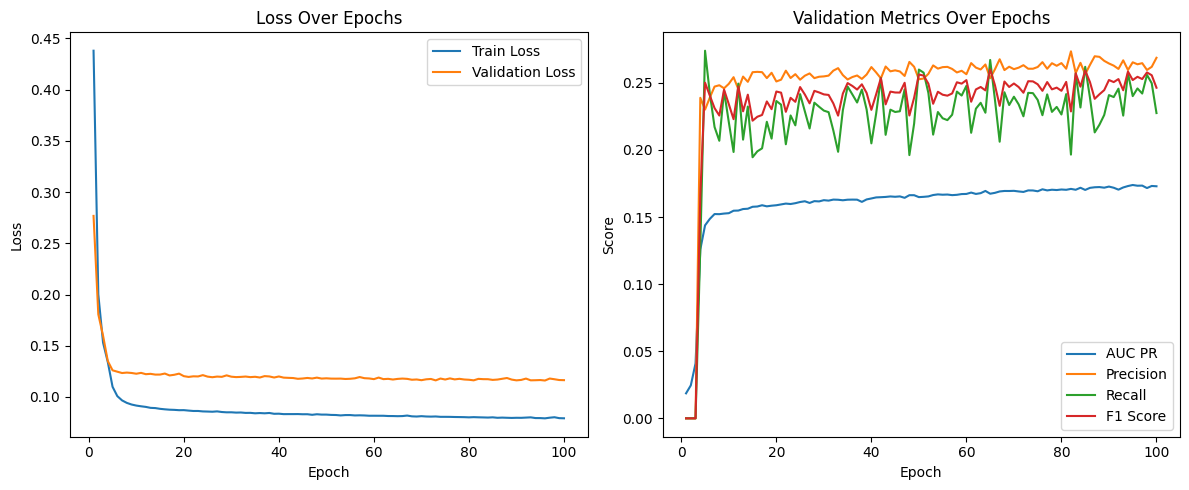

In [36]:
plot_training_history(histories_128[128])

In [38]:
import os
os.makedirs("saved_models", exist_ok=True)

In [39]:

model_path = f"saved_models/autoencoder_bs{batch}.pt"
torch.save(model_trained.state_dict(), model_path)
print(f"✅ Model saved at: {model_path}")

✅ Model saved at: saved_models/autoencoder_bs128.pt


In [41]:
import json
history_path = f"saved_models/history_bs{batch}.json"
with open(history_path, 'w') as f:
    json.dump(history, f)
print(f"✅ History saved at: {history_path}")

✅ History saved at: saved_models/history_bs128.json


### Deriving results for batch size 64

In [42]:
log_text = """
🔁 Training with batch size: 64
[Epoch 1/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 1/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]
New best model with AUC PR: 0.0200
Epoch [1/100] Train Loss: 0.3827 Val Loss: 0.1957 AUC PR: 0.0200 Precision: 0.0000 Recall: 0.0000 F1: 0.0000
[Epoch 2/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 2/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]
New best model with AUC PR: 0.0795
Epoch [2/100] Train Loss: 0.1554 Val Loss: 0.1501 AUC PR: 0.0795 Precision: 0.0990 Recall: 0.0022 F1: 0.0043
[Epoch 3/100] Training: 100%|██████████| 235/235 [02:50<00:00,  1.38it/s]
[Epoch 3/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.60it/s]
New best model with AUC PR: 0.1418
Epoch [3/100] Train Loss: 0.1154 Val Loss: 0.1278 AUC PR: 0.1418 Precision: 0.2367 Recall: 0.2453 F1: 0.2410
[Epoch 4/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.42it/s]
[Epoch 4/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]
New best model with AUC PR: 0.1461
Epoch [4/100] Train Loss: 0.0989 Val Loss: 0.1262 AUC PR: 0.1461 Precision: 0.2454 Recall: 0.2246 F1: 0.2345
[Epoch 5/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 5/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.77it/s]
New best model with AUC PR: 0.1540
Epoch [5/100] Train Loss: 0.0945 Val Loss: 0.1255 AUC PR: 0.1540 Precision: 0.2475 Recall: 0.2356 F1: 0.2414
[Epoch 6/100] Training: 100%|██████████| 235/235 [02:50<00:00,  1.38it/s]
[Epoch 6/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.82it/s]
Epoch [6/100] Train Loss: 0.0923 Val Loss: 0.1266 AUC PR: 0.1524 Precision: 0.2493 Recall: 0.2272 F1: 0.2377
[Epoch 7/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 7/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]
New best model with AUC PR: 0.1569
Epoch [7/100] Train Loss: 0.0912 Val Loss: 0.1251 AUC PR: 0.1569 Precision: 0.2574 Recall: 0.1949 F1: 0.2219
[Epoch 8/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 8/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]
Epoch [8/100] Train Loss: 0.0898 Val Loss: 0.1255 AUC PR: 0.1567 Precision: 0.2543 Recall: 0.2129 F1: 0.2318
[Epoch 9/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 9/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]
Epoch [9/100] Train Loss: 0.0892 Val Loss: 0.1237 AUC PR: 0.1567 Precision: 0.2509 Recall: 0.2317 F1: 0.2409
[Epoch 10/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 10/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.39it/s]
New best model with AUC PR: 0.1573
Epoch [10/100] Train Loss: 0.0885 Val Loss: 0.1246 AUC PR: 0.1573 Precision: 0.2552 Recall: 0.2068 F1: 0.2285
[Epoch 11/100] Training: 100%|██████████| 235/235 [02:49<00:00,  1.39it/s]
[Epoch 11/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.78it/s]
New best model with AUC PR: 0.1577
Epoch [11/100] Train Loss: 0.0882 Val Loss: 0.1222 AUC PR: 0.1577 Precision: 0.2583 Recall: 0.1959 F1: 0.2228
[Epoch 12/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 12/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]
New best model with AUC PR: 0.1592
Epoch [12/100] Train Loss: 0.0873 Val Loss: 0.1247 AUC PR: 0.1592 Precision: 0.2628 Recall: 0.1601 F1: 0.1990
[Epoch 13/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 13/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]
New best model with AUC PR: 0.1592
Epoch [13/100] Train Loss: 0.0873 Val Loss: 0.1223 AUC PR: 0.1592 Precision: 0.2561 Recall: 0.2193 F1: 0.2363
[Epoch 14/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 14/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]
Epoch [14/100] Train Loss: 0.0869 Val Loss: 0.1234 AUC PR: 0.1585 Precision: 0.2532 Recall: 0.2367 F1: 0.2446
[Epoch 15/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 15/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]
Epoch [15/100] Train Loss: 0.0866 Val Loss: 0.1229 AUC PR: 0.1579 Precision: 0.2564 Recall: 0.2215 F1: 0.2377
[Epoch 16/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 16/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]
Epoch [16/100] Train Loss: 0.0862 Val Loss: 0.1220 AUC PR: 0.1588 Precision: 0.2586 Recall: 0.2106 F1: 0.2321
[Epoch 17/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 17/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.79it/s]
New best model with AUC PR: 0.1603
Epoch [17/100] Train Loss: 0.0859 Val Loss: 0.1211 AUC PR: 0.1603 Precision: 0.2632 Recall: 0.1643 F1: 0.2023
[Epoch 18/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 18/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]
Epoch [18/100] Train Loss: 0.0856 Val Loss: 0.1213 AUC PR: 0.1596 Precision: 0.2613 Recall: 0.1906 F1: 0.2204
[Epoch 19/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 19/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]
New best model with AUC PR: 0.1607
Epoch [19/100] Train Loss: 0.0854 Val Loss: 0.1214 AUC PR: 0.1607 Precision: 0.2613 Recall: 0.1976 F1: 0.2250
[Epoch 20/100] Training: 100%|██████████| 235/235 [02:49<00:00,  1.39it/s]
[Epoch 20/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.66it/s]
New best model with AUC PR: 0.1612
Epoch [20/100] Train Loss: 0.0852 Val Loss: 0.1211 AUC PR: 0.1612 Precision: 0.2593 Recall: 0.2219 F1: 0.2392
[Epoch 21/100] Training: 100%|██████████| 235/235 [02:48<00:00,  1.40it/s]
[Epoch 21/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.72it/s]
New best model with AUC PR: 0.1623
Epoch [21/100] Train Loss: 0.0846 Val Loss: 0.1201 AUC PR: 0.1623 Precision: 0.2596 Recall: 0.2239 F1: 0.2404
[Epoch 22/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 22/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.74it/s]
New best model with AUC PR: 0.1627
Epoch [22/100] Train Loss: 0.0850 Val Loss: 0.1206 AUC PR: 0.1627 Precision: 0.2584 Recall: 0.2320 F1: 0.2445
[Epoch 23/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 23/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]
New best model with AUC PR: 0.1639
Epoch [23/100] Train Loss: 0.0848 Val Loss: 0.1203 AUC PR: 0.1639 Precision: 0.2670 Recall: 0.1584 F1: 0.1988
[Epoch 24/100] Training: 100%|██████████| 235/235 [02:48<00:00,  1.40it/s]
[Epoch 24/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.82it/s]
Epoch [24/100] Train Loss: 0.0841 Val Loss: 0.1192 AUC PR: 0.1636 Precision: 0.2591 Recall: 0.2286 F1: 0.2429
[Epoch 25/100] Training: 100%|██████████| 235/235 [02:49<00:00,  1.38it/s]
[Epoch 25/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.36it/s]
New best model with AUC PR: 0.1642
Epoch [25/100] Train Loss: 0.0842 Val Loss: 0.1199 AUC PR: 0.1642 Precision: 0.2577 Recall: 0.2407 F1: 0.2489
[Epoch 26/100] Training: 100%|██████████| 235/235 [02:48<00:00,  1.39it/s]
[Epoch 26/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.72it/s]
Epoch [26/100] Train Loss: 0.0837 Val Loss: 0.1208 AUC PR: 0.1636 Precision: 0.2575 Recall: 0.2381 F1: 0.2474
[Epoch 27/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 27/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.74it/s]
New best model with AUC PR: 0.1662
Epoch [27/100] Train Loss: 0.0837 Val Loss: 0.1189 AUC PR: 0.1662 Precision: 0.2665 Recall: 0.1926 F1: 0.2236
[Epoch 28/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 28/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.78it/s]
Epoch [28/100] Train Loss: 0.0836 Val Loss: 0.1187 AUC PR: 0.1659 Precision: 0.2575 Recall: 0.2497 F1: 0.2535
[Epoch 29/100] Training: 100%|██████████| 235/235 [02:50<00:00,  1.38it/s]
[Epoch 29/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.80it/s]
Epoch [29/100] Train Loss: 0.0833 Val Loss: 0.1191 AUC PR: 0.1660 Precision: 0.2620 Recall: 0.2271 F1: 0.2433
[Epoch 30/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 30/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]
New best model with AUC PR: 0.1673
Epoch [30/100] Train Loss: 0.0830 Val Loss: 0.1191 AUC PR: 0.1673 Precision: 0.2611 Recall: 0.2312 F1: 0.2452
[Epoch 31/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 31/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.55it/s]
New best model with AUC PR: 0.1674
Epoch [31/100] Train Loss: 0.0831 Val Loss: 0.1183 AUC PR: 0.1674 Precision: 0.2635 Recall: 0.2237 F1: 0.2419
[Epoch 32/100] Training: 100%|██████████| 235/235 [02:48<00:00,  1.40it/s]
[Epoch 32/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]
New best model with AUC PR: 0.1689
Epoch [32/100] Train Loss: 0.0828 Val Loss: 0.1178 AUC PR: 0.1689 Precision: 0.2652 Recall: 0.2236 F1: 0.2426
[Epoch 33/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.42it/s]
[Epoch 33/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]
Epoch [33/100] Train Loss: 0.0825 Val Loss: 0.1187 AUC PR: 0.1669 Precision: 0.2602 Recall: 0.2364 F1: 0.2478
[Epoch 34/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 34/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.79it/s]
New best model with AUC PR: 0.1696
Epoch [34/100] Train Loss: 0.0827 Val Loss: 0.1174 AUC PR: 0.1696 Precision: 0.2641 Recall: 0.2300 F1: 0.2459
[Epoch 35/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 35/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]
New best model with AUC PR: 0.1702
Epoch [35/100] Train Loss: 0.0824 Val Loss: 0.1182 AUC PR: 0.1702 Precision: 0.2709 Recall: 0.1941 F1: 0.2262
[Epoch 36/100] Training: 100%|██████████| 235/235 [02:47<00:00,  1.40it/s]
[Epoch 36/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.77it/s]
Epoch [36/100] Train Loss: 0.0824 Val Loss: 0.1181 AUC PR: 0.1700 Precision: 0.2653 Recall: 0.2315 F1: 0.2472
[Epoch 37/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 37/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]
Epoch [37/100] Train Loss: 0.0819 Val Loss: 0.1181 AUC PR: 0.1685 Precision: 0.2602 Recall: 0.2489 F1: 0.2544
[Epoch 39/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.42it/s]
[Epoch 39/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.43it/s]
Epoch [39/100] Train Loss: 0.0818 Val Loss: 0.1166 AUC PR: 0.1714 Precision: 0.2604 Recall: 0.2527 F1: 0.2565
[Epoch 40/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 40/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]
Epoch [40/100] Train Loss: 0.0816 Val Loss: 0.1167 AUC PR: 0.1723 Precision: 0.2636 Recall: 0.2430 F1: 0.2529
[Epoch 41/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 41/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]
New best model with AUC PR: 0.1725
Epoch [41/100] Train Loss: 0.0815 Val Loss: 0.1175 AUC PR: 0.1725 Precision: 0.2654 Recall: 0.2337 F1: 0.2486
[Epoch 42/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 42/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]
New best model with AUC PR: 0.1730
Epoch [42/100] Train Loss: 0.0815 Val Loss: 0.1157 AUC PR: 0.1730 Precision: 0.2705 Recall: 0.2192 F1: 0.2422
[Epoch 43/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 43/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]
New best model with AUC PR: 0.1736
Epoch [43/100] Train Loss: 0.0815 Val Loss: 0.1157 AUC PR: 0.1736 Precision: 0.2678 Recall: 0.2271 F1: 0.2458
[Epoch 44/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.42it/s]
[Epoch 44/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]
New best model with AUC PR: 0.1742
Epoch [44/100] Train Loss: 0.0813 Val Loss: 0.1175 AUC PR: 0.1742 Precision: 0.2766 Recall: 0.2000 F1: 0.2322
[Epoch 45/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 45/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]
New best model with AUC PR: 0.1754
Epoch [45/100] Train Loss: 0.0810 Val Loss: 0.1161 AUC PR: 0.1754 Precision: 0.2677 Recall: 0.2371 F1: 0.2515
[Epoch 47/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 47/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]
Epoch [47/100] Train Loss: 0.0808 Val Loss: 0.1163 AUC PR: 0.1750 Precision: 0.2671 Recall: 0.2433 F1: 0.2547
[Epoch 48/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 48/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]
Epoch [48/100] Train Loss: 0.0806 Val Loss: 0.1166 AUC PR: 0.1761 Precision: 0.2660 Recall: 0.2481 F1: 0.2568
[Epoch 49/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 49/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]
New best model with AUC PR: 0.1771
Epoch [49/100] Train Loss: 0.0805 Val Loss: 0.1161 AUC PR: 0.1771 Precision: 0.2756 Recall: 0.2183 F1: 0.2436
[Epoch 50/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 50/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.87it/s]
New best model with AUC PR: 0.1771
Epoch [50/100] Train Loss: 0.0807 Val Loss: 0.1159 AUC PR: 0.1771 Precision: 0.2652 Recall: 0.2530 F1: 0.2590
[Epoch 51/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 51/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]
New best model with AUC PR: 0.1790
Epoch [51/100] Train Loss: 0.0801 Val Loss: 0.1161 AUC PR: 0.1790 Precision: 0.2752 Recall: 0.2255 F1: 0.2479
[Epoch 53/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 53/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]
Epoch [53/100] Train Loss: 0.0802 Val Loss: 0.1163 AUC PR: 0.1776 Precision: 0.2683 Recall: 0.2456 F1: 0.2565
[Epoch 54/100] Training:  56%|█████▌    | 131/235 [01:32<01:11,  1.46it/s]
New best model with AUC PR: 0.1795
Epoch [54/100] Train Loss: 0.0802 Val Loss: 0.1157 AUC PR: 0.1795 Precision: 0.2705 Recall: 0.2453 F1: 0.2573
[Epoch 55/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 55/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.41it/s]
New best model with AUC PR: 0.1804
Epoch [55/100] Train Loss: 0.0799 Val Loss: 0.1153 AUC PR: 0.1804 Precision: 0.2704 Recall: 0.2490 F1: 0.2592
[Epoch 56/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 56/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]
Epoch [56/100] Train Loss: 0.0801 Val Loss: 0.1168 AUC PR: 0.1796 Precision: 0.2721 Recall: 0.2390 F1: 0.2545
[Epoch 57/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 57/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.78it/s]
New best model with AUC PR: 0.1807
Epoch [57/100] Train Loss: 0.0798 Val Loss: 0.1153 AUC PR: 0.1807 Precision: 0.2653 Recall: 0.2619 F1: 0.2636
[Epoch 58/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 58/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]
Epoch [58/100] Train Loss: 0.0797 Val Loss: 0.1147 AUC PR: 0.1804 Precision: 0.2715 Recall: 0.2473 F1: 0.2588
[Epoch 59/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 59/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]
Epoch [59/100] Train Loss: 0.0794 Val Loss: 0.1151 AUC PR: 0.1798 Precision: 0.2694 Recall: 0.2522 F1: 0.2605
[Epoch 61/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 61/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]
New best model with AUC PR: 0.1811
Epoch [61/100] Train Loss: 0.0796 Val Loss: 0.1173 AUC PR: 0.1811 Precision: 0.2723 Recall: 0.2496 F1: 0.2604
[Epoch 62/100] Training:  52%|█████▏    | 122/235 [01:25<01:17,  1.45it/s]
New best model with AUC PR: 0.1812
Epoch [62/100] Train Loss: 0.0795 Val Loss: 0.1162 AUC PR: 0.1812 Precision: 0.2758 Recall: 0.2380 F1: 0.2555
[Epoch 63/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 63/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]
New best model with AUC PR: 0.1823
Epoch [63/100] Train Loss: 0.0794 Val Loss: 0.1160 AUC PR: 0.1823 Precision: 0.2814 Recall: 0.2309 F1: 0.2536
[Epoch 64/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 64/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]
Epoch [64/100] Train Loss: 0.0792 Val Loss: 0.1141 AUC PR: 0.1821 Precision: 0.2629 Recall: 0.2776 F1: 0.2701
[Epoch 65/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 65/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.84it/s]
New best model with AUC PR: 0.1826
Epoch [65/100] Train Loss: 0.0793 Val Loss: 0.1156 AUC PR: 0.1826 Precision: 0.2703 Recall: 0.2604 F1: 0.2653
[Epoch 66/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 66/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]
Epoch [66/100] Train Loss: 0.0791 Val Loss: 0.1154 AUC PR: 0.1825 Precision: 0.2710 Recall: 0.2575 F1: 0.2641
[Epoch 67/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 67/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.95it/s]
New best model with AUC PR: 0.1844
Epoch [67/100] Train Loss: 0.0790 Val Loss: 0.1157 AUC PR: 0.1844 Precision: 0.2805 Recall: 0.2339 F1: 0.2551
[Epoch 69/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 69/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.43it/s]
Epoch [69/100] Train Loss: 0.0790 Val Loss: 0.1146 AUC PR: 0.1826 Precision: 0.2763 Recall: 0.2451 F1: 0.2598
[Epoch 70/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 70/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]
Epoch [70/100] Train Loss: 0.0785 Val Loss: 0.1149 AUC PR: 0.1836 Precision: 0.2720 Recall: 0.2616 F1: 0.2667
[Epoch 71/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 71/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.56it/s]
Epoch [71/100] Train Loss: 0.0786 Val Loss: 0.1151 AUC PR: 0.1834 Precision: 0.2719 Recall: 0.2571 F1: 0.2643
[Epoch 72/100] Training: 100%|██████████| 235/235 [02:42<00:00,  1.44it/s]
[Epoch 72/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.49it/s]
New best model with AUC PR: 0.1856
Epoch [72/100] Train Loss: 0.0788 Val Loss: 0.1153 AUC PR: 0.1856 Precision: 0.2812 Recall: 0.2411 F1: 0.2596
[Epoch 73/100] Training: 100%|██████████| 235/235 [02:42<00:00,  1.45it/s]
[Epoch 73/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]
Epoch [73/100] Train Loss: 0.0786 Val Loss: 0.1142 AUC PR: 0.1853 Precision: 0.2722 Recall: 0.2616 F1: 0.2668
[Epoch 74/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 74/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]
Epoch [74/100] Train Loss: 0.0784 Val Loss: 0.1165 AUC PR: 0.1839 Precision: 0.2655 Recall: 0.2738 F1: 0.2696
[Epoch 76/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 76/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.50it/s]
New best model with AUC PR: 0.1872
Epoch [76/100] Train Loss: 0.0783 Val Loss: 0.1143 AUC PR: 0.1872 Precision: 0.2790 Recall: 0.2512 F1: 0.2644
[Epoch 77/100] Training:  52%|█████▏    | 122/235 [01:25<01:15,  1.49it/s]
Epoch [77/100] Train Loss: 0.0780 Val Loss: 0.1145 AUC PR: 0.1860 Precision: 0.2752 Recall: 0.2557 F1: 0.2651
[Epoch 78/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 78/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.80it/s]
Epoch [78/100] Train Loss: 0.0782 Val Loss: 0.1151 AUC PR: 0.1859 Precision: 0.2830 Recall: 0.2354 F1: 0.2570
[Epoch 79/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 79/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]
Epoch [79/100] Train Loss: 0.0781 Val Loss: 0.1159 AUC PR: 0.1864 Precision: 0.2709 Recall: 0.2713 F1: 0.2711
[Epoch 81/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 81/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]
New best model with AUC PR: 0.1874
Epoch [81/100] Train Loss: 0.0782 Val Loss: 0.1156 AUC PR: 0.1874 Precision: 0.2834 Recall: 0.2427 F1: 0.2615
[Epoch 82/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 82/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]
Epoch [82/100] Train Loss: 0.0780 Val Loss: 0.1145 AUC PR: 0.1864 Precision: 0.2770 Recall: 0.2544 F1: 0.2652
[Epoch 83/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 83/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.83it/s]
Epoch [83/100] Train Loss: 0.0778 Val Loss: 0.1158 AUC PR: 0.1845 Precision: 0.2674 Recall: 0.2768 F1: 0.2720
[Epoch 84/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 84/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.89it/s]
Epoch [84/100] Train Loss: 0.0777 Val Loss: 0.1153 AUC PR: 0.1865 Precision: 0.2738 Recall: 0.2671 F1: 0.2704
[Epoch 85/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 85/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.91it/s]
Epoch [85/100] Train Loss: 0.0780 Val Loss: 0.1159 AUC PR: 0.1858 Precision: 0.2628 Recall: 0.2884 F1: 0.2750
[Epoch 86/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 87/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 87/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]
Epoch [87/100] Train Loss: 0.0775 Val Loss: 0.1156 AUC PR: 0.1863 Precision: 0.2694 Recall: 0.2740 F1: 0.2717
[Epoch 88/100] Training:  58%|█████▊    | 136/235 [01:35<01:08,  1.44it/s]
Epoch [88/100] Train Loss: 0.0776 Val Loss: 0.1157 AUC PR: 0.1861 Precision: 0.2728 Recall: 0.2649 F1: 0.2688
[Epoch 89/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.43it/s]
[Epoch 89/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]
New best model with AUC PR: 0.1885
Epoch [89/100] Train Loss: 0.0775 Val Loss: 0.1157 AUC PR: 0.1885 Precision: 0.2791 Recall: 0.2593 F1: 0.2688
[Epoch 90/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 90/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]
Epoch [90/100] Train Loss: 0.0777 Val Loss: 0.1160 AUC PR: 0.1863 Precision: 0.2763 Recall: 0.2580 F1: 0.2668
[Epoch 92/100] Training: 100%|██████████| 235/235 [02:43<00:00,  1.44it/s]
[Epoch 92/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.86it/s]
Epoch [92/100] Train Loss: 0.0774 Val Loss: 0.1147 AUC PR: 0.1882 Precision: 0.2679 Recall: 0.2835 F1: 0.2755
[Epoch 93/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 93/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s]
Epoch [93/100] Train Loss: 0.0772 Val Loss: 0.1153 AUC PR: 0.1871 Precision: 0.2714 Recall: 0.2731 F1: 0.2723
[Epoch 94/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 94/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s]
Epoch [94/100] Train Loss: 0.0774 Val Loss: 0.1148 AUC PR: 0.1858 Precision: 0.2673 Recall: 0.2824 F1: 0.2747
[Epoch 95/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 95/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.88it/s]
Epoch [95/100] Train Loss: 0.0775 Val Loss: 0.1143 AUC PR: 0.1885 Precision: 0.2834 Recall: 0.2458 F1: 0.2632
[Epoch 96/100] Training: 100%|██████████| 235/235 [02:45<00:00,  1.42it/s]
[Epoch 96/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]
Epoch [96/100] Train Loss: 0.0773 Val Loss: 0.1145 AUC PR: 0.1869 Precision: 0.2737 Recall: 0.2645 F1: 0.2690
[Epoch 97/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 97/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.40it/s]
Epoch [97/100] Train Loss: 0.0770 Val Loss: 0.1143 AUC PR: 0.1866 Precision: 0.2658 Recall: 0.2789 F1: 0.2722
[Epoch 98/100] Training: 100%|██████████| 235/235 [02:46<00:00,  1.41it/s]
[Epoch 98/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]
Epoch [98/100] Train Loss: 0.0771 Val Loss: 0.1166 AUC PR: 0.1889 Precision: 0.2783 Recall: 0.2587 F1: 0.2681
[Epoch 99/100] Training: 100%|██████████| 235/235 [02:49<00:00,  1.39it/s]
[Epoch 99/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.76it/s]
Epoch [99/100] Train Loss: 0.0771 Val Loss: 0.1155 AUC PR: 0.1882 Precision: 0.2794 Recall: 0.2528 F1: 0.2654
[Epoch 100/100] Training: 100%|██████████| 235/235 [02:44<00:00,  1.43it/s]
[Epoch 100/100] Validation: 100%|██████████| 30/30 [00:06<00:00,  4.92it/s]
Epoch [100/100] Train Loss: 0.0769 Val Loss: 0.1151 AUC PR: 0.1887 Precision: 0.2630 Recall: 0.2988 F1: 0.2798

Final Model Performance:
AUC PR: 0.1887
Precision: 0.2630
Recall: 0.2988
F1 Score: 0.2798
"""

In [43]:
import re
# Pattern to extract training metrics from each epoch
pattern = re.compile(
    r"Epoch \[(\d+)/100\] Train Loss: ([\d.]+) Val Loss: ([\d.]+) "
    r"AUC PR: ([\d.]+) Precision: ([\d.]+) Recall: ([\d.]+) F1: ([\d.]+)"
)

# Extract matches
matches = pattern.findall(log_text)

# Convert to DataFrame
history_df = pd.DataFrame(matches, columns=[
    "Epoch", "Train Loss", "Val Loss", "AUC PR", "Precision", "Recall", "F1"
])

# Convert numeric columns to proper types
history_df = history_df.astype({
    "Epoch": int,
    "Train Loss": float,
    "Val Loss": float,
    "AUC PR": float,
    "Precision": float,
    "Recall": float,
    "F1": float
})

# Sort by epoch
history_df = history_df.sort_values("Epoch").reset_index(drop=True)

# Optional: Save to CSV
history_df.to_csv("history_batch64.csv", index=False)

# Display
history_df.head()

,Epoch,Train Loss,Val Loss,AUC PR,Precision,Recall,F1
0,1,0.3827,0.1957,0.0200,0.0000,0.0000,0.0000
1,2,0.1554,0.1501,0.0795,0.0990,0.0022,0.0043
2,3,0.1154,0.1278,0.1418,0.2367,0.2453,0.2410
3,4,0.0989,0.1262,0.1461,0.2454,0.2246,0.2345
4,5,0.0945,0.1255,0.1540,0.2475,0.2356,0.2414


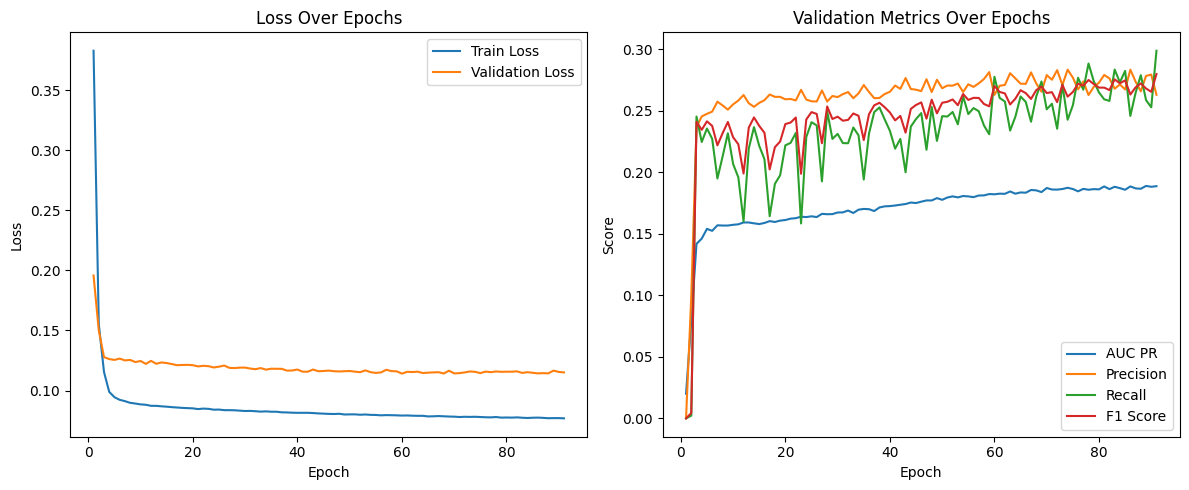

In [46]:
history_dict_64 = {
    'train_loss': history_df['Train Loss'].tolist(),
    'val_loss': history_df['Val Loss'].tolist(),
    'val_auc_pr': history_df['AUC PR'].tolist(),
    'val_precision': history_df['Precision'].tolist(),
    'val_recall': history_df['Recall'].tolist(),
    'val_f1_score': history_df['F1'].tolist()
}
plot_training_history(history_dict_64)